# Problem Statement:

### In the field of dermatology, accurate and early detection of melanoma is crucial for improving patient outcomes. Melanoma, a serious form of skin cancer, can be fatal if not identified and treated promptly. To support dermatologists in the diagnostic process and reduce the manual effort involved in analyzing skin images, we propose to develop a custom Convolutional Neural Network (CNN) model using TensorFlow.

### The objective of this project is to build and train a CNN-based classification model that can effectively distinguish between melanoma and other types of skin lesions from a dataset of dermatological images. The dataset comprises 2,357 images classified into ten categories, including melanoma, and other skin conditions such as actinic keratosis, basal cell carcinoma, and seborrheic keratosis.

### Key Goals:

#### Data Preprocessing: Prepare and preprocess the images for training, including resizing, normalization, and augmentation if necessary.
#### Model Development: Design and implement a CNN architecture tailored for the classification of skin lesions.
#### Training and Validation: Train the CNN model using the provided dataset, ensuring robust validation to evaluate its performance.
#### Evaluation Metrics: Assess the model’s accuracy, precision, recall, and F1-score, focusing particularly on the sensitivity and specificity for melanoma detection.
#### Deployment Considerations: Explore potential approaches for integrating the trained model into diagnostic tools or applications for practical use by dermatologists.
#### By achieving these goals, the project aims to develop a reliable tool that can assist in the early detection of melanoma, ultimately contributing to improved patient care and reduced diagnostic workload for healthcare professionals.

In [1]:
### Importing all the important libraries
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [44]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk.

### Create a dataset

Define some parameters for the loader:

In [18]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [19]:
# Create the training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [21]:
# Create the validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [22]:
# List out all the classes of skin cancer and store them in a list.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

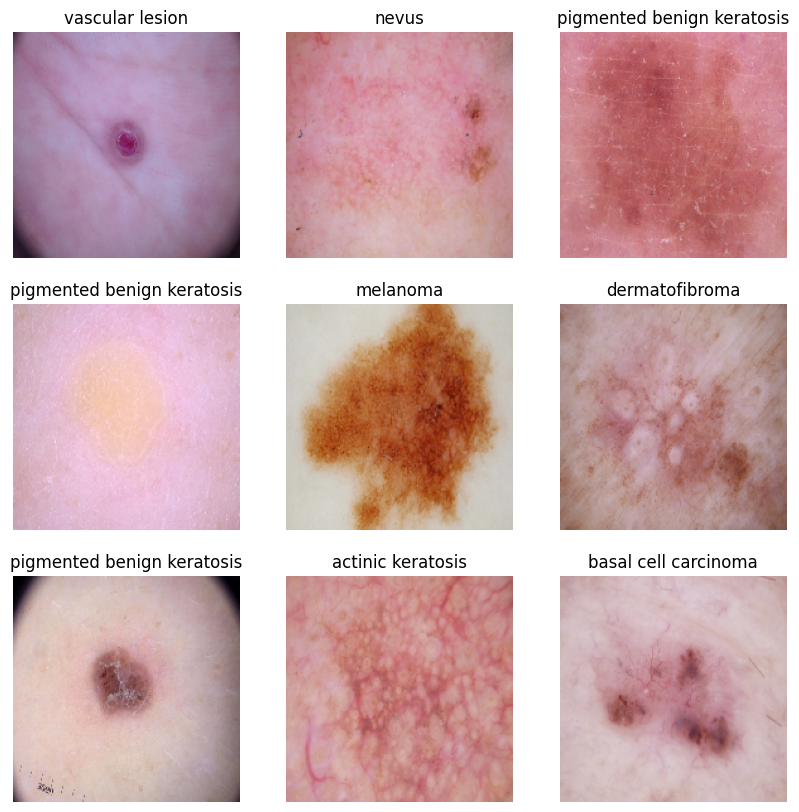

In [23]:
import matplotlib.pyplot as plt

#Visualizing the Training Data
# Function to visualize images

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [24]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [25]:
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [26]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 435s 3s/step - loss: 1.9421 - accuracy: 0.3092 - val_loss: 1.6465 - val_accuracy: 0.3982
Epoch 2/20
56/56 [==============================] - 67s 1s/step - loss: 1.5850 - accuracy: 0.4308 - val_loss: 1.5088 - val_accuracy: 0.4877
Epoch 3/20
56/56 [==============================] - 62s 1s/step - loss: 1.4236 - accuracy: 0.4944 - val_loss: 1.4745 - val_accuracy: 0.4989
Epoch 4/20
56/56 [==============================] - 66s 1s/step - loss: 1.3138 - accuracy: 0.5402 - val_loss: 1.3853 - val_accuracy: 0.5391
Epoch 5/20
56/56 [==============================] - 63s 1s/step - loss: 1.2703 - accuracy: 0.5485 - val_loss: 1.4262 - val_accuracy: 0.5213
Epoch 6/20
56/56 [==============================] - 63s 1s/step - loss: 1.1710 - accuracy: 0.5854 - val_loss: 1.3498 - val_accuracy: 0.5391
Epoch 7/20
56/56 [==============================] - 67s 1s/step - loss: 1.0639 - accuracy: 0.6205 - val_loss: 1.3611 - val_accuracy: 0.5414
Epoch 8/20
56/56 [=

### Visualizing training results

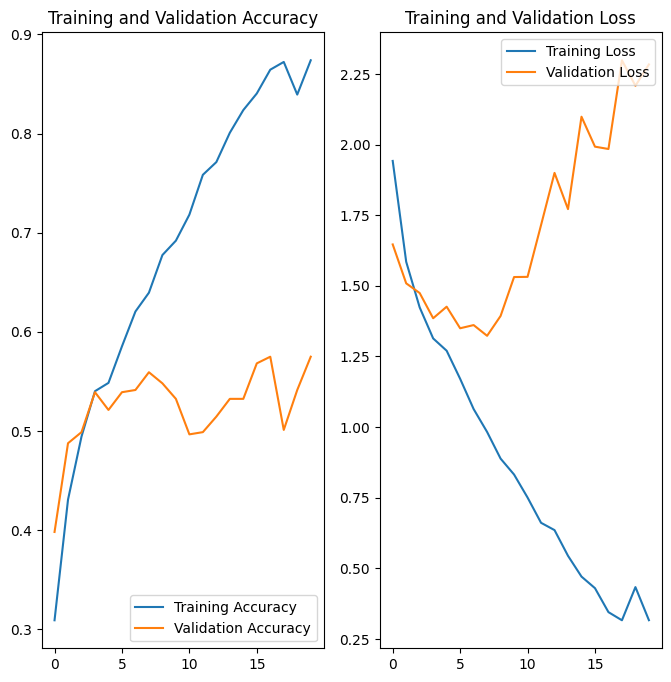

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Example Finding:
The model shows signs of slight overfitting as the training accuracy is higher than the validation accuracy and the training loss is lower than the validation loss. However, the difference is not very large, indicating the model is performing reasonably well but could benefit from further regularization or more training data.

In [30]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

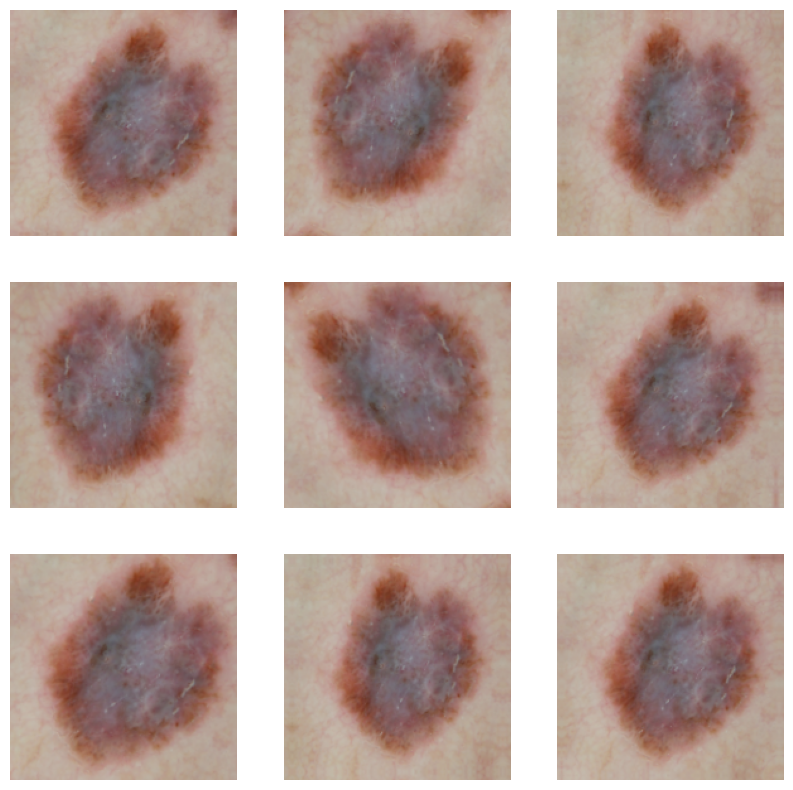

In [31]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model

In [32]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])



### Compiling the model

In [33]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [34]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 79s 1s/step - loss: 2.0790 - accuracy: 0.2238 - val_loss: 1.9034 - val_accuracy: 0.3132
Epoch 2/20
56/56 [==============================] - 82s 1s/step - loss: 1.8628 - accuracy: 0.2991 - val_loss: 1.7925 - val_accuracy: 0.3244
Epoch 3/20
56/56 [==============================] - 79s 1s/step - loss: 1.7384 - accuracy: 0.3811 - val_loss: 1.6257 - val_accuracy: 0.4228
Epoch 4/20
56/56 [==============================] - 79s 1s/step - loss: 1.6039 - accuracy: 0.4453 - val_loss: 1.6172 - val_accuracy: 0.4228
Epoch 5/20
56/56 [==============================] - 74s 1s/step - loss: 1.5230 - accuracy: 0.4487 - val_loss: 1.5550 - val_accuracy: 0.4340
Epoch 6/20
56/56 [==============================] - 75s 1s/step - loss: 1.3719 - accuracy: 0.5190 - val_loss: 1.3630 - val_accuracy: 0.5145
Epoch 7/20
56/56 [==============================] - 77s 1s/step - loss: 1.3022 - accuracy: 0.5324 - val_loss: 1.3300 - val_accuracy: 0.5056
Epoch 8/20
56/56 [==

### Visualizing the results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The second set of graphs shows that the training accuracy and validation accuracy are closer to each other compared to the first set, indicating a reduction in overfitting. However, the accuracy levels are lower in the second set.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [35]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

2239

In [36]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/drive/MyDrive/Skin cancer ISIC The In...,pigmented benign keratosis
1,/content/drive/MyDrive/Skin cancer ISIC The In...,pigmented benign keratosis
2,/content/drive/MyDrive/Skin cancer ISIC The In...,pigmented benign keratosis
3,/content/drive/MyDrive/Skin cancer ISIC The In...,pigmented benign keratosis
4,/content/drive/MyDrive/Skin cancer ISIC The In...,pigmented benign keratosis
...,...,...
2234,/content/drive/MyDrive/Skin cancer ISIC The In...,actinic keratosis
2235,/content/drive/MyDrive/Skin cancer ISIC The In...,actinic keratosis
2236,/content/drive/MyDrive/Skin cancer ISIC The In...,actinic keratosis
2237,/content/drive/MyDrive/Skin cancer ISIC The In...,actinic keratosis


Class=5, n=462 (20.634%)
Class=6, n=77 (3.439%)
Class=7, n=181 (8.084%)
Class=4, n=357 (15.945%)
Class=1, n=376 (16.793%)
Class=2, n=95 (4.243%)
Class=8, n=139 (6.208%)
Class=3, n=438 (19.562%)
Class=0, n=114 (5.092%)


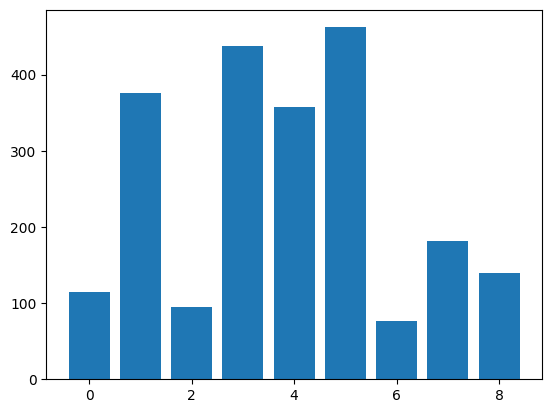

In [37]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter
# split into input and output elements
X, y = original_df['Path'], original_df['Label']
# label encode the target variable
y = LabelEncoder().fit_transform(y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

Here, Class 6 has least number of sample, and 1,3,4,5 classes dominate the data in terms proportionate number of samples.

#### **Todo:** Rectify the class imbalance
#### We can use a python package known as `Augmentor` to add more samples across all classes so that none of the classes have very few samples.

In [38]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [57]:
path_to_training_dataset="/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
import os
import Augmentor

# Verify the path and check directories
for i in class_names:
    full_path = os.path.join(path_to_training_dataset, i)
    print(f"Checking path: {full_path}")

    if not os.path.exists(full_path):
        print(f"Directory does not exist: {full_path}")
        continue

    if not os.listdir(full_path):
        print(f"Directory is empty: {full_path}")
        continue

    print(f"Directory exists and is not empty: {full_path}")
    # Initialize Augmentor Pipeline
    p = Augmentor.Pipeline(full_path)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)  # Generate 500 samples per class


Checking path: /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis
Directory exists and is not empty: /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis
Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C24EB03B820>: 100%|██████████| 500/500 [00:33<00:00, 14.86 Samples/s]


Checking path: /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma
Directory exists and is not empty: /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma
Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C24EAD59C90>: 100%|██████████| 500/500 [00:31<00:00, 15.63 Samples/s]


Checking path: /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma
Directory exists and is not empty: /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma
Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C24EAD5A410>: 100%|██████████| 500/500 [00:30<00:00, 16.33 Samples/s]


Checking path: /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma
Directory exists and is not empty: /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma
Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7C24EB614910>: 100%|██████████| 500/500 [02:22<00:00,  3.52 Samples/s]


Checking path: /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus
Directory exists and is not empty: /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus
Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7C24EA9B6380>: 100%|██████████| 500/500 [01:33<00:00,  5.32 Samples/s]


Checking path: /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis
Directory exists and is not empty: /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis
Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C24EB3CC7C0>: 100%|██████████| 500/500 [00:24<00:00, 20.28 Samples/s]


Checking path: /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis
Directory exists and is not empty: /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis
Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7C24FAF177F0>: 100%|██████████| 500/500 [00:52<00:00,  9.48 Samples/s]


Checking path: /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma
Directory exists and is not empty: /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma
Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7C24EB00F100>: 100%|██████████| 500/500 [00:23<00:00, 21.44 Samples/s]


Checking path: /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion
Directory exists and is not empty: /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion
Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7C24EB3CF9D0>: 100%|██████████| 500/500 [00:25<00:00, 19.63 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [58]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

9000


### Lets see the distribution of augmented data after adding new images to the original training data.

In [59]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024705.jpg_fdc1f6cd-6c18-4338-a66c-26023d509026.jpg',
 '/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028080.jpg_3d29ff3a-a7c2-4efc-9927-1bae1d33abd2.jpg',
 '/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026444.jpg_f0731d81-d8fe-4adc-b8cc-2ac461f2f8b2.jpg',
 '/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026607.jpg_b75e8268-2580-4909-b40a-267761822b6c.jpg',
 '/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benig

In [60]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmen

In [62]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [65]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = pd.concat([original_df, df2], ignore_index=True)

In [66]:
new_df['Label'].value_counts()

Label
pigmented benign keratosis    1462
melanoma                      1438
basal cell carcinoma          1376
nevus                         1357
squamous cell carcinoma       1181
vascular lesion               1139
actinic keratosis             1114
dermatofibroma                1095
seborrheic keratosis          1077
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [67]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [68]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


#### **Todo:** Create a validation dataset

In [69]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [70]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [71]:
## your code goes here

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [72]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
281/281 [==============================] - 410s 1s/step - loss: 1.6020 - accuracy: 0.3838 - val_loss: 1.3888 - val_accuracy: 0.4726
Epoch 2/20
281/281 [==============================] - 352s 1s/step - loss: 1.1768 - accuracy: 0.5664 - val_loss: 1.0372 - val_accuracy: 0.6168
Epoch 3/20
281/281 [==============================] - 341s 1s/step - loss: 0.8958 - accuracy: 0.6725 - val_loss: 0.9290 - val_accuracy: 0.6698
Epoch 4/20
281/281 [==============================] - 330s 1s/step - loss: 0.6870 - accuracy: 0.7530 - val_loss: 0.7066 - val_accuracy: 0.7588
Epoch 5/20
281/281 [==============================] - 328s 1s/step - loss: 0.5249 - accuracy: 0.8144 - val_loss: 0.6864 - val_accuracy: 0.7717
Epoch 6/20
281/281 [==============================] - 334s 1s/step - loss: 0.4062 - accuracy: 0.8578 - val_loss: 0.6259 - val_accuracy: 0.7962
Epoch 7/20
281/281 [==============================] - 343s 1s/step - loss: 0.3589 - accuracy: 0.8736 - val_loss: 0.6166 - val_accuracy: 0.7975

#### **Todo:**  Visualize the model results

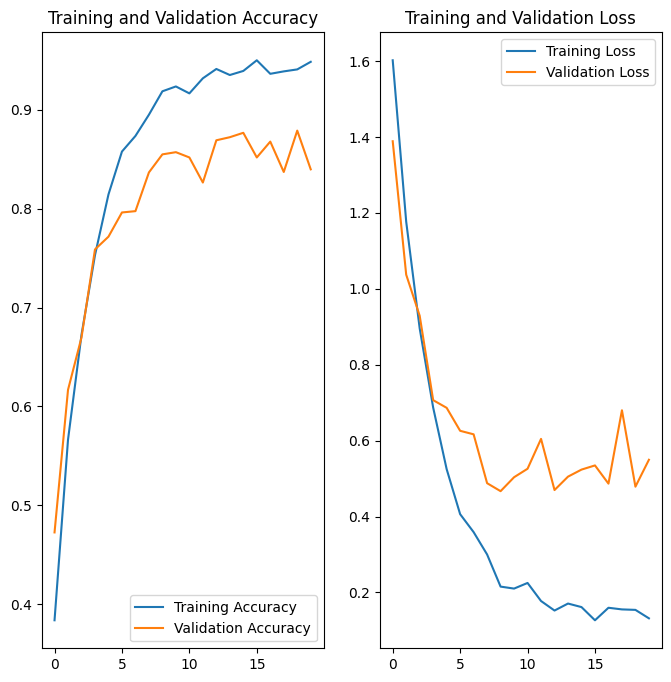

In [73]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()